# SVD Image Compression

## Project Goals

This notebook shows the process of image compression using Singular Value Decomposition (SVD) and visually explores its effects on varied grayscale images, evaluating performance using PSNR and compression ratio.


In particular, this project aims to:
* Show how SVD retains or loses fine-grain patterns in images with rich textures.

* Test how SVD handles fine details and whether using a low number of singular values (k) effectively captures focal points in images.

* Observe SVD's performance on simple images with only structural information.

* Evaluate how well SVD handles gradual changes in brightness and slight brightness variations across vast areas.

## 1. Imports and Setup

In [ ]:
# Install required packages (for Colab use)
!pip install scikit-image matplotlib
!pip install kneed

# Imports
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.metrics import peak_signal_noise_ratio as psnr
from google.colab import files
from kneed import KneeLocator

## 2. Upload and Load Images

In [2]:
# Upload and load image
uploaded = files.upload()

# Convert to grayscale
ferret = color.rgb2gray(io.imread('ferret_portrait.jpg'))
foot = color.rgb2gray(io.imread('foot_sketch.jpg'))
mountains = color.rgb2gray(io.imread('mountain_landscape.jpg'))

# Precompute SVDs to reuse later
svd_data = {
    'ferret': np.linalg.svd(ferret, full_matrices = False),
    'foot': np.linalg.svd(foot, full_matrices = False),
    'mountain': np.linalg.svd(mountains, full_matrices = False)
    }

Saving foot_sketch.jpg to foot_sketch (1).jpg
Saving mountain_landscape.jpg to mountain_landscape (1).jpg
Saving ferret_portrait.jpg to ferret_portrait (1).jpg


### Rationale Behind Image Selection

**Ferret Portrait**

*   Rich Textures
  > This grayscale version highlights textures such as the *ferret's fur* and the *texture* of the *blanket*. Useful to **show how SVD keeps or loses fine-grain patterns.**
*   High detail density in small area
  > The ferret's *face and eyes* are very detailed and encapsulate a small region. Great to **test how SVD handles fine details and whether low k captures focal points effectively.**


**Foot Sketch**

*   Minimalist content with *clean lines*, *no shading*
  > Because of this image's simplicity, this will be a great image to **observe how SVD performs when there's only structural information.**

*   High edge importance
  > Since the sketch is basically a *simple outline* of feet, even **small losses from compression will be easy to spot.**



**Mountain Landscape**

*   Gradients and natural structures
  > This image contains *soft transitions* such as clouds and reflections. Tests to see **how SVD handles gradual changes in brightness.**

*   Visually complex
  > Tests to see **how SVD works on vast areas that have slight brightness variations.**





## 3. Reconstruction Function & Define SVD

In [3]:
# Reconstruction function

def reconstruct_image(U, S, VT, k):
  S_k = np.diag(S[:k]) # Keep only top k singular values
  return np.dot(U[:, :k], np.dot(S_k, VT[:k, :]))

In [4]:
# Reconstruct image using top k singular values

def svd_plot(image, title, U, S, VT):
  ks = [10, 50, 100, 200]
  fig, axes = plt.subplots(1, len(ks) + 1, figsize = (18,5))
  fig.suptitle(title, fontsize = 20)

  # Original image
  axes[0].imshow(image, cmap = 'gray')
  axes[0].set_title('Original Image')
  axes[0].axis('off')

  original_size = image.size # Approximates original uncompressed size as total # of pixels

  # Show compressed versions
  for i, k in enumerate(ks):
    compressed = reconstruct_image(U, S, VT, k)
    psnr_value = psnr(image, compressed)
    compressed_size = U[:, :k].size + S[:k].size + VT[:k, :].size
    compressed_ratio = original_size / compressed_size

    axes[i + 1].imshow(compressed, cmap = 'gray')
    axes[i + 1].set_title(f'k = {k}\nPSNR = {psnr_value:.2f} dB\nRatio = {compressed_ratio:.2f}x')
    axes[i + 1].axis('off')

  plt.tight_layout()
  plt.subplots_adjust(top = .7)
  plt.show()

## 4. Visualize Compression with SVD, PSNR Labels, and Compression Ratio

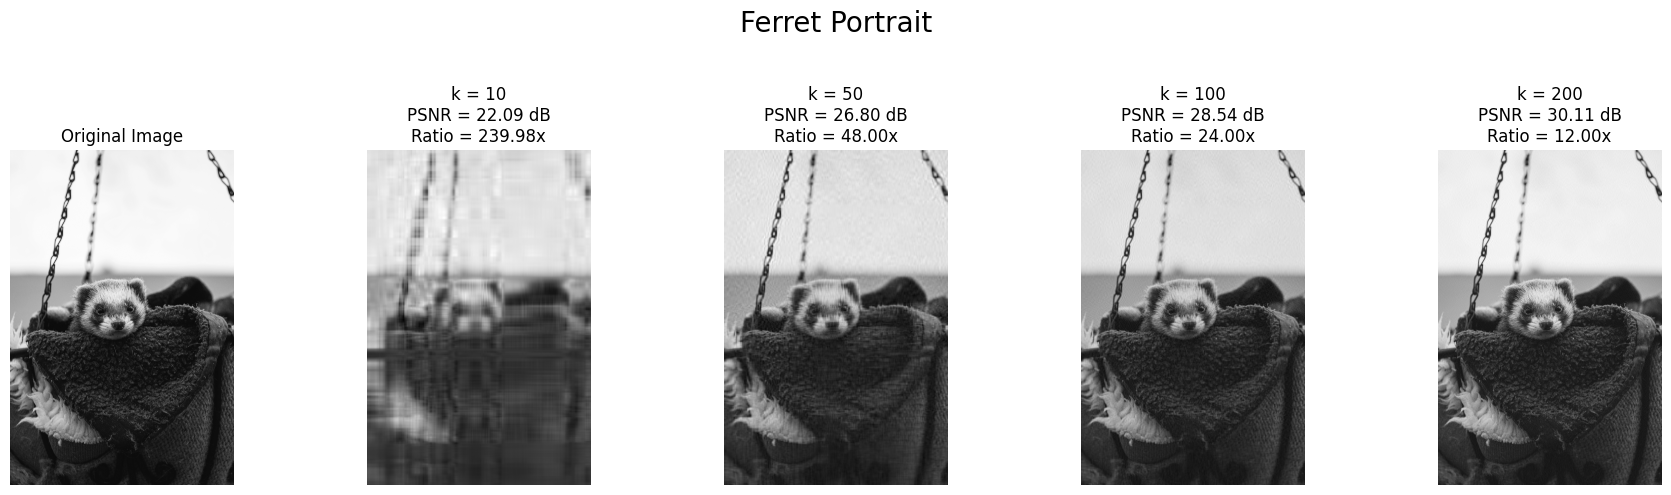

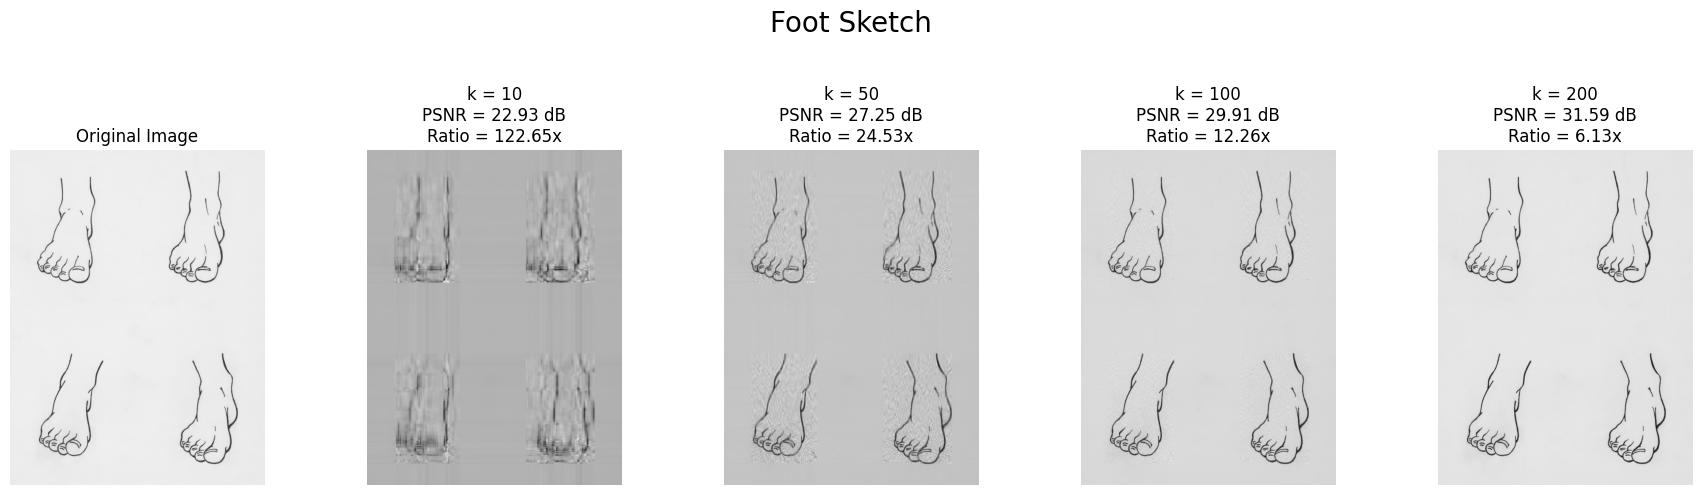

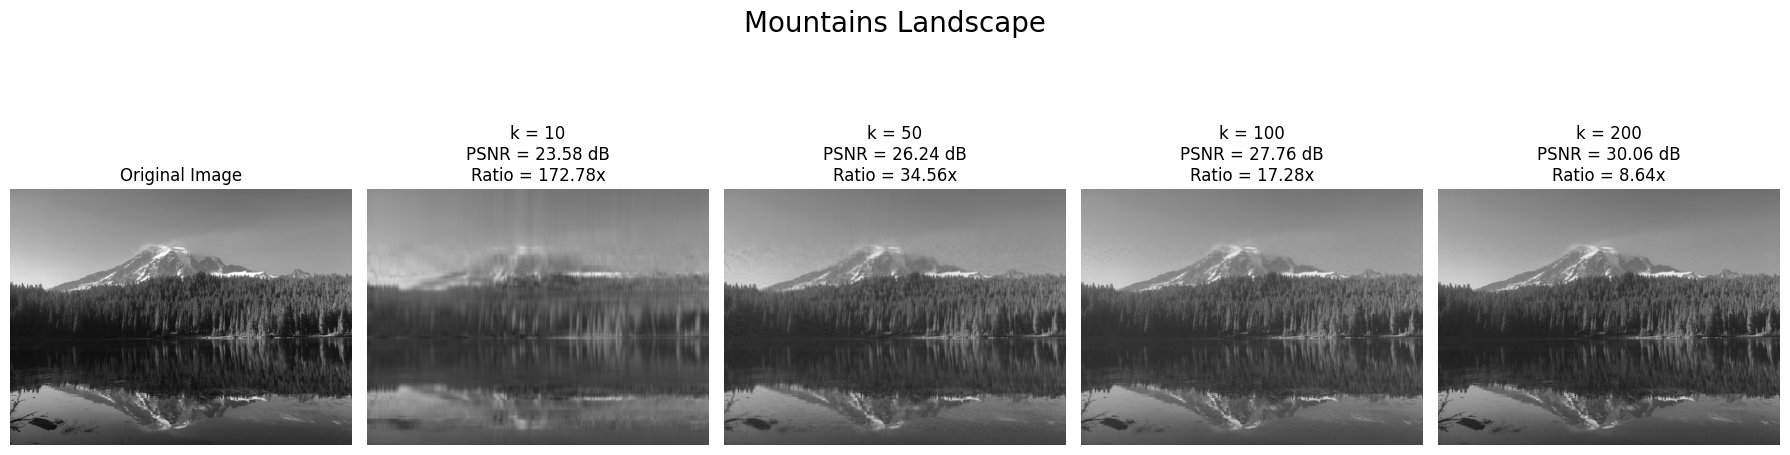

In [5]:
# Visualizing SVD compression

U_f, S_f, VT_f = svd_data['ferret']
svd_plot(ferret, 'Ferret Portrait', U_f, S_f, VT_f)

U_foot, S_foot, VT_foot = svd_data['foot']
svd_plot(foot, 'Foot Sketch', U_foot, S_foot, VT_foot)

U_m, S_m, VT_m = svd_data['mountain']
svd_plot(mountains, 'Mountains Landscape', U_m, S_m, VT_m)

## General Observations
Based on the visualizations, we see that as k increases, the **compression ratio decreases**. k is *inversely proportional* to the compression ratio.


> *   At **k = 10**, the compression ratio is very high (ie. ~240x for the Ferret Portrait) but the image quality suffers.
  *   details of the image are mostly lost (appears very *blurry*).
*   At **k = 100**, the ratio significantly drops (ie. 24x). This provides a better balance between images quality and compression.
  *   appears to *preserve details* of the Original Image much better.

---
## Image-specific observations

### Ferret Portrait
*   At **k = 10**:
  *   The ferret's head shape/markings are still *somewhat visible*, but the *facial details blur out quickly*.
*   At **k = 100**:
  *   The *texture* of the ferret's fur and blanket return.

### Foot Sketch
*   At **k = 10**:
  *   Rough outline is visible, but unable to make out fine details (ie. toenails).
*   At **k = 50**:
  *   *Almost identical* to Orginal Image, suggesting strong compressibility.


  > Simplier images, such as this one, seems to maintain decent quality even at low k values.


### Mountain Landscape
*   At **k = 10**:
  *   The vertical lines of the trees seem to blur with the rest of the background.
*   At **k = 100**:
  *   Image's *edges and clarity* returns.

---

### How Image Complexity Affects Compression Results

*   **Foot Sketch**: Simple, high contrast, and line-based. Its simplicity allows for clear recontructions, even with low k values.
*   **Ferret Portrait**: Contains *fine textures* like fur and fabric that blur out quickly at low k values.
*   **Mountain Landscape**: Contains fine, *natural gradients* (ie. trees, hills) that easily blur together when compression ratio is too large.
    *   Both the **Ferret Portrait** (fine textures0 and the **Mountain Landscape** (natural gradients) require more singular values (k) to reconstruct well.



> Simpler images tend to compress better. Complex images with involved textures and gradients need higher k value to preserve visual quality.







### PSNR vs. k Plot

Elbow point for 'Ferret Portrait': k = 110
Elbow point for 'Foot Sketch': k = 125
Elbow point for 'Mountain Landscape': k = 110


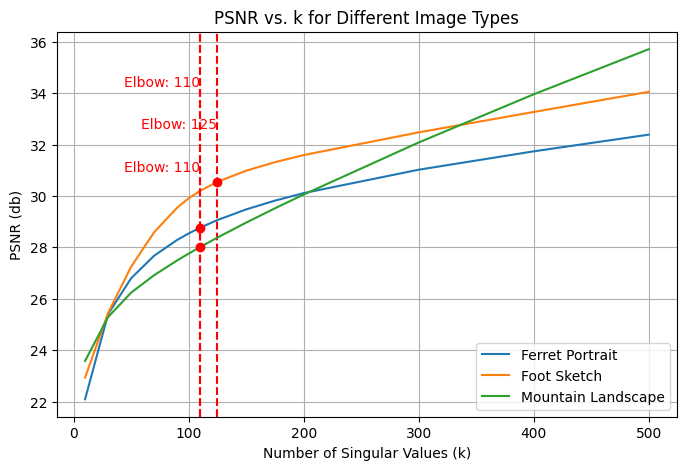

In [6]:
# Plot PSNR vs. k using KneeLocator
def psnr_plot(images, titles = ''):
  k_values = [10, 30, 50, 70, 90, 100, 110, 125, 150, 175, 200, 300, 400, 500]
  elbow_ks = []

  plt.figure(figsize = (8, 5))

  for image, title in zip(images, titles):
    U, S, VT = svd_data[title.lower().split()[0]]
    psnr_scores = []

    # Compute image quality (PSNR) for each compression level
    for k in k_values:
      compressed = reconstruct_image(U, S, VT, k)
      score = psnr(image, compressed)
      psnr_scores.append(score)

    plt.plot(k_values, psnr_scores, label = title)

    # Detect elbow k value
    kneedle = KneeLocator(k_values, psnr_scores, curve = 'concave', direction = 'increasing')
    elbow_k = kneedle.knee # This is the optimal k (elbow)
    elbow_ks.append(elbow_k) # Save for later use

    # If an elbow WAS found, mark it on the plot
    if elbow_k is not None:
      # Get interpolated PSNR value at elbow_k (in case k is between listed items)
      elbow_psnr = np.interp(elbow_k, k_values, psnr_scores)
      plt.axvline(x = elbow_k, color = 'red', linestyle = '--')
      plt.plot(elbow_k, elbow_psnr, marker = 'o', color = 'red', markersize = 6)
      plt.text(elbow_k, max(psnr_scores) -1, f'Elbow: {elbow_k}', color = 'red', va = 'top', ha = 'right')
      print(f"Elbow point for '{title}': k = {elbow_k}")
    else:
      print(f"No clear elbow found for '{title}'")


  plt.title('PSNR vs. k for Different Image Types')
  plt.xlabel('Number of Singular Values (k)')
  plt.ylabel('PSNR (db)')
  plt.legend()
  plt.grid(True)
  plt.show()

  return elbow_ks

elbows = psnr_plot([ferret, foot, mountains], ['Ferret Portrait', 'Foot Sketch', 'Mountain Landscape'])

elbow_k_ferret, elbow_k_foot, elbow_k_mountains = elbows

The **elbow method** refers to the *point* where the PSNR curve begins to noticeably *plateau*, signaling that increasing k any further leads to only minor gains in an image's quality.

*   While lower k values may already produce visually acceptable images (to the human eye), the elbow marks the point in which further gains offer diminishing *statistical* returns, not necessarily visual ones.

### Compression Ratio vs. k Plot

Ferret Portrait - Elbow k: 110, Compression Ratio:  21.82


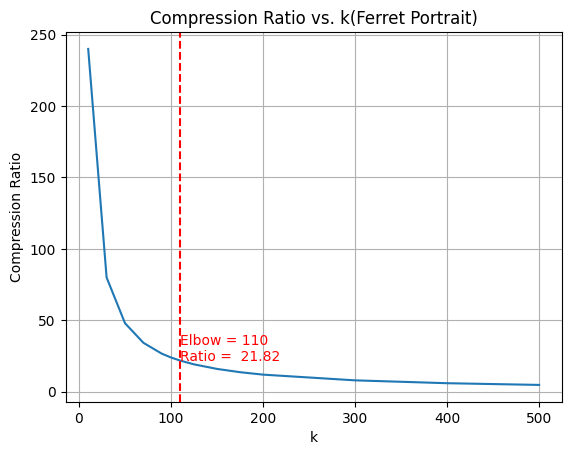

Foot Sketch - Elbow k: 125, Compression Ratio:  9.81


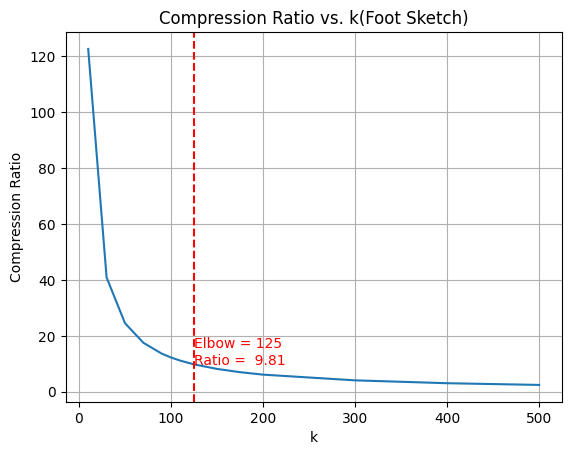

Mountain Landscape - Elbow k: 110, Compression Ratio:  15.71


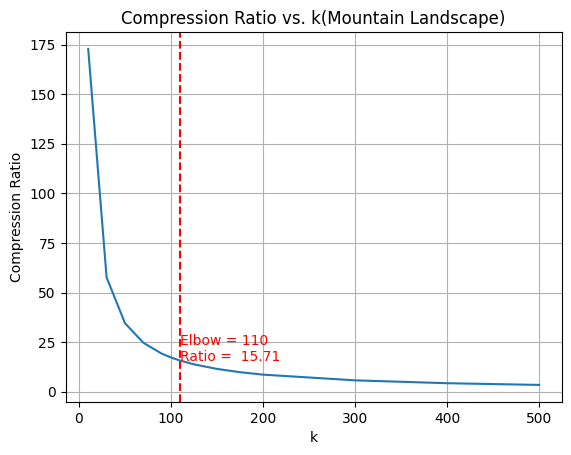

In [7]:
# Function that plots how compression ratio changes with k
def compression_ratio_plot(image, title, elbow_k = None):
  U, S, VT = svd_data[title.lower().split()[0]]
  original_size = image.size
  k_values = [10, 30, 50, 70, 90, 100, 110, 125, 150, 175, 200, 300, 400, 500]
  ratios = []

  for k in k_values:
    compressed_size = U[:, :k].size + S[:k].size + VT[:k, :].size #Approximate compressed size using number of elements in U_k, S_k, and VT_k (ignores data types and storage overhead for simplicity)
    ratios.append(original_size / compressed_size)

  plt.plot(k_values, ratios)
  plt.title(f'Compression Ratio vs. k({title})')
  plt.xlabel('k')
  plt.ylabel('Compression Ratio')
  plt.grid(True)

# Estimating the ratio at the elbow k using interpolation
  if elbow_k:
    ratio_at_elbow = np.interp(elbow_k, k_values, ratios)
    plt.axvline(x = elbow_k, color = 'red', linestyle = '--')
    plt.text(elbow_k, ratio_at_elbow, f'Elbow = {elbow_k}\nRatio = {ratio_at_elbow: .2f}', color = 'red')
    print(f'{title} - Elbow k: {elbow_k}, Compression Ratio: {ratio_at_elbow: .2f}')

  plt.show()

compression_ratio_plot(ferret, 'Ferret Portrait', elbow_k = elbow_k_ferret)
compression_ratio_plot(foot, 'Foot Sketch', elbow_k = elbow_k_foot)
compression_ratio_plot(mountains, 'Mountain Landscape', elbow_k = elbow_k_mountains)

These plots show how the **compression ratio** changes as the number of singular values (k) used in SVD reconstruction increases.

**Compression ratio = original size ÷ compressed size**

*   **Higher** compression **ratio** = **better storage savings**.
*   As k increases, more singular values information is retained, so compression becomes **less efficient**.










**Elbow Points (red dashed lines)**

The **elbow point** for each plot (Ferret Portrait, Foot Sketch, and Mountain Landscape) represents the point where increasing k yields diminishing returns in image quality (from PSNR).
  *   These were computed using the KneeLocator on the PSNR vs. k plots.
  *   The elbow values were then **passed to this plot** to show the corresponding sotrage efficiency at those same quality-optimal points.

*   At the elbow:
  *   **Ferret Portrait**: Elbow k = 110
  *   **Foot Sketch**: Elbow k = 125
  *   **Mountain Landscape**: Elbow k = 110


Note:

*   Using elbow values from the PSNR curves ensures that the compression plots are directly tied to actual image quality behavior.
*   If the curves change due to (ie. new images), the compressions plots will update automatically.
*   Helps to visualize the trade-off between storage savings and the level off reconstruction detail retained.


---



**Interpretation**



**Image Characteristics**:

The Foot Sketch consistently shows higher PSNR at lower k values.
 * Likely easier to compress due to the image's simplicity (high contrast, clean lines, low texture).

The Ferret Portrait and Mountain Landscape require higher k to preserve quality.

* Likely more difficult to compress due to their complex textures and intricate features, which require more singular components to preserve quality.

**Quality vs. Storage**:

The **Compression Ratio vs. k** plot shows that there is a clear trade-off:
*   As k increases:
  *   **PSNR increases** → improved image quality.
  *   But the **compression ratio decreases** (more storage required)

The elbow point mark is practical because:


*   Around k = 100-125, you get **most of the perceptual quality** while keeping **reasonable compression**.
*   This makes SVD compression **efficient** and **customizeable**, depending on whether your priority is quality or file size.

**General Observations**

PSNR increases rapidly when increasing k from 10 → 50 → 100.
  *  Reflecting significant quality gains early on.

However, the gains **diminish** after k ≈ 100:
  *   k =100 → 200: Moderate improvement
  *   k = 200 → 300: Minimal gains
    *   suggesting that further increasing k has limited impact on perceived quality


This trend aligns with the established elbow points using KneeLocator:
  *   Ferret Portrait: k ≈ 110
  *   Foot Sketch: k ≈ 125
  *   Mountain Landscape: k ≈ 110

Beyond these points, PSNR flattens, which indicates the **optimal k** for quality-efficiency balance.

## 5. Conclusion

**Key Insights**

This project provided a comprehensive understanding of Singular Value Decomposition (SVD) and its powerful application in image compression. Through practical implementation and analysis, I gained several key insights:

* **SVD's Core Mechanism**: I learned how SVD decomposes an image into fundamental singular values, revealing its underlying structure and the relative importance of different features for data representation.

* **Dimensionality Reduction**: The project effectively demonstrated SVD's power in dimensionality reduction. By retaining only the most significant singular values, it is possible to reconstruct clear, visually acceptable images from dramatically reduced data, highlighting an image's essential information.

* **The Quality-Storage Compromise**: A major part of my learning was understanding the direct relationship between image quality (PSNR) and compression ratio. The k value proved critical and enabled a customizable balance between visual fidelity and file size reduction. I observed that early increases in k yielded substantial quality improvements, showcasing an "elbow point" where further increases offered diminishing returns.

* **Practical Application of Linear Algebra**: This image proccessing project brought theoretical linear algebra concepts, particularly SVD, to life by demonstrating their direct application in everyday life. It solidified my understanding of eigenvalues/singular values in a practical context.

Overall, this project served to display SVD as an effective, customizable method for image compression, ( while balancing visual quality with storage efficiency), and deepening my appreciation for its mathematical principles.

## Limitations & Future Work

**Limitations**:

Despite being shown that SVD offers a great method for image compression throughout this project, it is important to acknowledge certain limitations:

* **Limited Image Dataset**: The analysis focuses on 3 images. Though I tried to pick 3 images that were distinct from each other, they may not be fully representative of image types and complexities, which affects the generalizability of observation.

* **Focus on grayscale image compression**: The project effectively demonstrates SVD on grayscale images. This simplifies application of SVD but also limits the opportunity for color image compression.

* **Reliance on PSNR to score quality**: As I alluded to earlier, PSNR is a quantitative measure, derived from statistical calculations. It may not always reflect human visual awareness.


---



**Future Work**:

Here are some potential avenues for further research, improvements to the model, and new methods to explore:


* **Optimize for large datasets**: For practical applications involving a large amount of images, optimizing the computational efficiency of SVD would be crucial. This might involve exploring methods such as AutoEncoders to handle larger volumes of image data more efficiently.

* **Extend to allow color images**: The current project effectively demonstrates SVD on grayscale images. Future work could involve extending the methodology to compress color images. This may mean decomposing the color impage into 3 separate color channels (red, green, blue).

* **Incorporate Perceptual Quality Metrics**: Integrating perceptual quality metrics such as the Structural Similarity Index Measure (SSIM), which offers a more holistic approach, by taking into account multiple aspects of human visual perception. Using this in conjunction with PSNR would allow for a more complete assessment of visual fidelity and more accurately reflect how humans perceive image quality.